In [3]:
from __future__ import division
from __future__ import print_function
from __future__ import absolute_import

In [4]:
import os
import pandas as pd
import tensorflow as tf
import google.datalab.bigquery as dlbq

In [5]:
print(tf.__version__)
if tf.test.is_built_with_cuda():
    print ("Built with cuda")
if tf.test.is_gpu_available():
    print("GPU available.")

1.12.0


In [6]:
tf.test.is_built_with_cuda()

False

In [7]:
tf.logging.set_verbosity(tf.logging.INFO)

---
##### From Jupyter notebook to python package
From exploration to production.

This little tool dumps a given function to a file with the same name in a certain package

In [8]:
PACKAGE="./train"
from tools import make_src_dumper
write_py = make_src_dumper(PACKAGE)

---

# Training and Evaluation Data
Training and evaluation data should be provided in files already.

If not, please go back an run ```Processing_ATL_JUNE.ipynb```

#### Fetch a sample file for examination

In [12]:
DATASET='samples'
a_training_file = !gsutil ls gs://going-tfx/$DATASET/train_data/atl_june_csv-00000-of-*
a_training_file = a_training_file[0]
TEMP_DIR='/tmp/atl_june/{}'.format(DATASET)
!rm -rf $TEMP_DIR
!mkdir -p $TEMP_DIR
!gsutil cp $a_training_file $TEMP_DIR
a_training_file = !ls $TEMP_DIR
a_training_file = os.path.join(TEMP_DIR,a_training_file[0])
res=!wc -l $a_training_file
res=res[0].split(" ")
print()
print("{} records in {}".format(res[0], res[1]))

Copying gs://going-tfx/samples/train_data/atl_june_csv-00000-of-00024...
/ [1 files][141.4 KiB/141.4 KiB]                                                
Operation completed over 1 objects/141.4 KiB.                                    

1000 records in /tmp/atl_june/samples/atl_june_csv-00000-of-00024


#### Have a look into the first training data file

This data is at the **training data** stage. It's got all and only the columns we want. Is has been normalized and integerized. We'll use the ```tf.feature_column``` API to further prepare categorical features.

In [13]:
from train.model_config import ORDERED_TRAINING_COLUMNS
probe = pd.read_csv(a_training_file, names=ORDERED_TRAINING_COLUMNS)
probe.sample(frac=1.0)[:2]

,AIRLINE,ARR,ARR_DELAY,ARR_LAT,ARR_LON,DEP_DELAY,DEP_DOW,DEP_HOD,DEP_LAT,DEP_LON,DIFF_LAT,DIFF_LON,DISTANCE,MEAN_TEMP_ARR,MEAN_TEMP_DEP,MEAN_VIS_ARR,MEAN_VIS_DEP,WND_SPD_ARR,WND_SPD_DEP
335,0,13,-6.0,38.94,-77.46,0.078493,2,18,33.63,-84.42,0.488613,0.864046,0.102870,0.570397,0.592437,0.408602,0.59375,0.005101,0.372093
560,2,3,-13.0,40.69,-74.16,0.076923,6,11,33.63,-84.42,0.528870,0.899484,0.150884,0.391697,0.760504,0.473118,1.00000,0.012501,0.263566


In [14]:
probe.describe()

,AIRLINE,ARR,ARR_DELAY,ARR_LAT,ARR_LON,DEP_DELAY,DEP_DOW,DEP_HOD,DEP_LAT,DEP_LON,DIFF_LAT,DIFF_LON,DISTANCE,MEAN_TEMP_ARR,MEAN_TEMP_DEP,MEAN_VIS_ARR,MEAN_VIS_DEP,WND_SPD_ARR,WND_SPD_DEP
count,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00,1000.00,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,1.367000,44.106000,17.270000,35.45627,-86.816130,0.107582,3.696000,14.435000,33.63,-84.42,0.408472,0.763572,0.123891,0.522581,0.556386,0.435118,0.700406,0.006080,0.374411
std,2.387889,36.831227,35.743373,5.25087,11.891074,0.052509,1.726431,4.623327,0.00,0.00,0.120793,0.127696,0.104027,0.133286,0.234825,0.077546,0.281966,0.002626,0.109097
min,0.000000,0.000000,-29.000000,18.33000,-157.920000,0.058085,1.000000,6.000000,33.63,-84.42,0.014493,0.000000,0.000000,0.153430,0.109244,0.112903,0.000000,0.000200,0.263566
25%,0.000000,12.750000,-5.000000,31.32000,-90.500000,0.076923,2.000000,10.000000,33.63,-84.42,0.313320,0.724012,0.059060,0.431408,0.424370,0.408602,0.593750,0.004200,0.263566
50%,1.000000,35.000000,6.000000,35.43000,-83.310000,0.083987,4.000000,14.000000,33.63,-84.42,0.407867,0.801224,0.103682,0.546931,0.592437,0.470430,0.687500,0.005701,0.364341
75%,2.000000,68.000000,28.250000,39.87000,-80.040000,0.117739,6.000000,18.000000,33.63,-84.42,0.510007,0.836340,0.147357,0.615523,0.760504,0.489247,1.000000,0.007401,0.449612
max,18.000000,169.000000,267.000000,61.17000,-64.970000,0.503925,6.000000,23.000000,33.63,-84.42,1.000000,0.998174,1.000000,0.951263,0.928571,0.806452,1.000000,0.018602,0.612403


---
# ```tf.data``` input function

#### These input functions read from any number of files containing pre-processed data
In our parlour, this data is at the **training stage**. It's been fetched from a BigQuery table and pre-processed. It's not what'll come in at prediction time!

That pre-processing function has been stored in a metadata directory that is available to us to treat data at prediction time (**signature stage**) exactly the same way that our training data has been treated.

#### Read from TFRecords
This is highly optimized for throughput, but files are not that easy to play with

In [15]:
def make_tfr_input_fn(filename_pattern, batch_size, shuffle_buffer_size=10000, distribute=False,
                     reader_num_threads=16, parser_num_threads=16, sloppy_ordering=True,
                      prefetch_buffer_size=1024):
    
    import tensorflow as tf
    from train.model_config import LABEL_COLUMN
    from train.model_config import TRAINING_METADATA

    feature_spec = TRAINING_METADATA.schema.as_feature_spec()

    def _input_fn():
        dataset = tf.data.experimental.make_batched_features_dataset(
            file_pattern=filename_pattern,
            batch_size=batch_size,
            features=feature_spec,
            shuffle_buffer_size=shuffle_buffer_size,
            prefetch_buffer_size=prefetch_buffer_size,
            reader_num_threads=reader_num_threads,
            parser_num_threads=parser_num_threads,
            sloppy_ordering=sloppy_ordering,
            label_key=LABEL_COLUMN)

        if distribute:
            return dataset 
        else:
            return dataset.make_one_shot_iterator().get_next()
    return _input_fn

write_py(make_tfr_input_fn)

'make_tfr_input_fn written to ./train/make_tfr_input_fn.py.'

---
#### Verify the input_function's behaviour
```make_input_fn()``` returns an input_function. This function will be passed to the estimator, such that the estimator can call it in its own session/graph context to create a particularly useful input tensor. That input tensor will return the next batch of input records whenever it is evaluated. Let's create that tensor ourselves to see it in action.

In [19]:
with tf.Session() as sess:
    train_input_fn = make_tfr_input_fn(
        "gs://going-tfx/{}/train_data/atl_june_tfr-00000-of-00024".format(DATASET), batch_size=2)
    input = train_input_fn()
    res = [sess.run(input) for i in range(1)]
res

[({'AIRLINE': array([1, 2]),
   'ARR': array([83, 53]),
   'ARR_LAT': array([40.47, 42.96], dtype=float32),
   'ARR_LON': array([-88.91, -83.74], dtype=float32),
   'DEP_DELAY': array([0.07378336, 0.07535322], dtype=float32),
   'DEP_DOW': array([6, 5]),
   'DEP_HOD': array([17,  8]),
   'DEP_LAT': array([33.63, 33.63], dtype=float32),
   'DEP_LON': array([-84.42, -84.42], dtype=float32),
   'DIFF_LAT': array([0.52380955, 0.5810904 ], dtype=float32),
   'DIFF_LON': array([0.7410867 , 0.79660654], dtype=float32),
   'DISTANCE': array([0.10285335, 0.12829283], dtype=float32),
   'MEAN_TEMP_ARR': array([0.54512626, 0.31588444], dtype=float32),
   'MEAN_TEMP_DEP': array([0.75210077, 0.605042  ], dtype=float32),
   'MEAN_VIS_ARR': array([0.48387095, 0.4784946 ], dtype=float32),
   'MEAN_VIS_DEP': array([1.   , 0.875], dtype=float32),
   'WND_SPD_ARR': array([0.01020102, 0.00260026], dtype=float32),
   'WND_SPD_DEP': array([0.39534882, 0.2868217 ], dtype=float32)},
  array([-27.,   1.], dtyp

----
#### Read from CSV
Not so good for production, but may come handy for exploration.

In [20]:
def make_input_fn(filename_pattern, batch_size, shuffle_buffer_size=None, distribute=False):

    import tensorflow as tf
    from train.model_config import ORDERED_TRAINING_DEFAULTS
    from train.model_config import ORDERED_TRAINING_COLUMNS
    from train.model_config import LABEL_COLUMN
    
    
    def _input_fn():
        filenames = tf.gfile.Glob(filename_pattern)
        dataset = tf.data.TextLineDataset(filenames)

        def decode_csv(row):
            cols = tf.decode_csv(row, record_defaults=ORDERED_TRAINING_DEFAULTS)
            features = dict(zip(ORDERED_TRAINING_COLUMNS, cols))
            return features

        def pop_target(features):
            target = features.pop(LABEL_COLUMN)
            return features, target
        
        if shuffle_buffer_size is not None:
            dataset = dataset.shuffle(buffer_size=shuffle_buffer_size)
                
        dataset = (dataset.repeat()
                   .map(decode_csv)
                   .map(pop_target)
                   .batch(batch_size))
        
        if distribute:
            return dataset 
        else:
            return dataset.make_one_shot_iterator().get_next()
    
    return _input_fn

write_py(make_input_fn)

'make_input_fn written to ./train/make_input_fn.py.'

In [21]:
with tf.Session() as sess:
    train_input_fn = make_input_fn(
        "gs://going-tfx/{}/eval_data/*".format(DATASET), batch_size=2)
    input = train_input_fn()
    res = [sess.run(input) for i in range(1)]
res

[({'AIRLINE': array([5, 5], dtype=int32),
   'ARR': array([58, 43], dtype=int32),
   'ARR_LAT': array([30.19, 36.12], dtype=float32),
   'ARR_LON': array([-97.67, -86.67], dtype=float32),
   'DEP_DELAY': array([0.07692308, 0.10204082], dtype=float32),
   'DEP_DOW': array([1, 5], dtype=int32),
   'DEP_HOD': array([16, 17], dtype=int32),
   'DEP_LAT': array([33.63, 33.63], dtype=float32),
   'DEP_LON': array([-84.42, -84.42], dtype=float32),
   'DIFF_LAT': array([0.2873246 , 0.42374048], dtype=float32),
   'DIFF_LON': array([0.6470146, 0.7651418], dtype=float32),
   'DISTANCE': array([0.16594191, 0.03058177], dtype=float32),
   'MEAN_TEMP_ARR': array([0.7635379 , 0.54512626], dtype=float32),
   'MEAN_TEMP_DEP': array([0.91176444, 0.75210077], dtype=float32),
   'MEAN_VIS_ARR': array([0.4892473 , 0.45698923], dtype=float32),
   'MEAN_VIS_DEP': array([0.70312506, 1.        ], dtype=float32),
   'WND_SPD_ARR': array([0.00580058, 0.00330033], dtype=float32),
   'WND_SPD_DEP': array([0.496124

We evaluated the input tensor twice to each time receive a batch of 2 examples from the list of input files.

---
# Additional feature engineering for categorical columns

Categorical columns need to be treated once more to derive at numerical input suitable for model training. That involves bucketizing, the use of dictionaries, feature crossing and embedding

#### Find ranges to bucketize latitude and longitude 
We can easily understand the range of values with the help of a bq query and ```pandas.describe()```

In [22]:
query="""
select 
    distinct arrival_airport as airport, arrival_lat as lat, arrival_lon as lon 
from 
    `bigquery-samples.airline_ontime_data.flights`
"""
locations = dlbq.Query(query).execute().result().to_dataframe()
locations.describe()

,lat,lon
count,344.000000,344.000000
mean,38.491570,-98.531599
std,8.547964,21.746974
min,13.480000,-176.640000
25%,33.450000,-111.675000
50%,38.715000,-93.300000
75%,42.907500,-82.497500
max,71.280000,-64.800000


In [23]:
lat_boundaries = range(10,80,5)
lat_boundaries

[10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75]

In [24]:
lon_boundaries = range(-100, -55, 5)
lon_boundaries

[-100, -95, -90, -85, -80, -75, -70, -65, -60]

We're going to use those boundaries in the function below

#### Using tf feature_column api for bucketizing, crossing and embedding

In [25]:
def create_feature_columns():
    
    from tensorflow.feature_column import indicator_column as ind
    from tensorflow.feature_column import numeric_column as num
    from tensorflow.feature_column import bucketized_column as buck
    from tensorflow.feature_column import crossed_column as cross
    from tensorflow.feature_column import embedding_column as emb
    from tensorflow.feature_column import categorical_column_with_identity as cid
    
    ################################################################
    #  Numerical columns for the pre-processed features
    ################################################################
    feature_columns = [
        num(col) for col in [
            'DEP_DELAY',  
            'MEAN_TEMP_DEP','MEAN_VIS_DEP','WND_SPD_DEP',
            'MEAN_TEMP_ARR','MEAN_VIS_ARR','WND_SPD_ARR',
            'DIFF_LAT','DIFF_LON','DISTANCE']]
    
    ################################################################
    #  categorical from ints, bucket counts from examination of the 
    #  full dataset
    ################################################################
    airline = ind(cid('AIRLINE', num_buckets=30))
    arrival = ind(cid('ARR', num_buckets=400))
    
    ################################################################
    #  Crossed and embedded
    ################################################################
    lat_boundaries = range(10,80,5)
    lon_boundaries = range(-100, -55, 5)
    cross_size = len(lat_boundaries) * len(lon_boundaries)

    arr_geo_emb = emb(cross([
        buck(num('ARR_LAT'), lat_boundaries), 
        buck(num('ARR_LON'), lon_boundaries)], cross_size), 10)

    dep_geo_emb = emb(cross([
        buck(num("DEP_LAT"), lat_boundaries), 
        buck(num("DEP_LON"), lon_boundaries)], cross_size), 10)

    dep_how_emb = emb(cross([
        cid("DEP_HOD", num_buckets=24), 
        cid("DEP_DOW", num_buckets=8)], 7*24), 10)

    ################################################################
    #  all together
    ################################################################
    return (
        feature_columns + 
        [airline, arrival] +
        [dep_how_emb, arr_geo_emb, dep_geo_emb])
    
write_py(create_feature_columns)

'create_feature_columns written to ./train/create_feature_columns.py.'

In [26]:
create_feature_columns()

[_NumericColumn(key='DEP_DELAY', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 _NumericColumn(key='MEAN_TEMP_DEP', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 _NumericColumn(key='MEAN_VIS_DEP', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 _NumericColumn(key='WND_SPD_DEP', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 _NumericColumn(key='MEAN_TEMP_ARR', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 _NumericColumn(key='MEAN_VIS_ARR', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 _NumericColumn(key='WND_SPD_ARR', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 _NumericColumn(key='DIFF_LAT', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 _NumericColumn(key='DIFF_LON', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 _NumericColumn(key='DISTANCE', shape=(1,), defa

These feature columns encode a construction plan. The ```tf.feature_column.input_column()``` helper will construct a sub-graph from this plan and feed the root (the *result*) of the graph into the model. You see the pattern: All parts of the tensor graph are created within the session/graph context of the ```Estimator``` API. Never outside of it.

---
# Hypothesis, model function and custom estimator

#### The hypothesis
This computational sub-graph represents the trainable hypothesis

In [27]:
def make_hypothesis(input_layer, options):
    
    import tensorflow as tf
        
    out = tf.layers.dense(input_layer, 1, activation=None)

    return out
    
write_py(make_hypothesis)

'make_hypothesis written to ./train/make_hypothesis.py.'

#### The model function
The model function is responsible for providing different variants of the actual model suitable for training, evaluation and prediction

In [28]:
def make_model_fn(feature_columns, options):
    
    import tensorflow as tf
    from train.make_hypothesis import make_hypothesis
    
    def _model_fn(features, labels, mode):

        input_layer = tf.feature_column.input_layer( 
            features, feature_columns=feature_columns)

        #############################################################
        # This single line is the actual model
        #############################################################
        out = make_hypothesis(input_layer, options)

        if mode == tf.estimator.ModeKeys.PREDICT:
            return tf.estimator.EstimatorSpec(mode, predictions=out)


        labels = tf.expand_dims(labels, -1)
        loss = tf.losses.mean_squared_error(labels, out)

        if mode == tf.estimator.ModeKeys.EVAL:    
            return tf.estimator.EstimatorSpec(
                mode=mode,
                loss = loss,
                #eval_metric_ops={'my_metric': }
            )

        else:
            optimizer = tf.train.GradientDescentOptimizer(options['learning_rate'])
            train_op = optimizer.minimize(loss, global_step=tf.train.get_or_create_global_step())

            return tf.estimator.EstimatorSpec(  
                mode,
                loss = loss,
                train_op = train_op)
        
    return _model_fn
write_py(make_model_fn)

'make_model_fn written to ./train/make_model_fn.py.'

---
# The tft serving input function
The saved ```transform_fn``` of the preprocessing step is recovered and applied to the **signature** input, which is represented by placeholders.
This function will be exported together with the ```tf.feature_columns``` transforms after training, to make sure that exactly the same preprocessing steps will be executed at prediction time.
The estimator will apply this function to the signature data coming at prediction time. The result will then be feed into the graph constructed with the help of the ```feature_columns``` API.

In [29]:
def make_tft_serving_input_fn(metadata_dir):

    import tensorflow as tf
    import tensorflow_transform as tft
    from train.model_config import SIGNATURE_INT_COLUMNS
    from train.model_config import SIGNATURE_FLOAT_COLUMNS
    from train.model_config import SIGNATURE_STR_COLUMNS
        
    def _input_fn():
        # placeholders for all the raw inputs
        placeholders = {
            key: tf.placeholder(name = key, shape=[None], dtype=tf.int64)
            for key in SIGNATURE_INT_COLUMNS
        }
        placeholders.update({
            key: tf.placeholder(name = key, shape=[None], dtype=tf.float32)
            for key in SIGNATURE_FLOAT_COLUMNS
        })

        placeholders.update({
            key: tf.placeholder(name = key, shape=[None], dtype=tf.string)
            for key in SIGNATURE_STR_COLUMNS
        })

        # transform using the saved model in transform_fn        
        transform_output = tft.TFTransformOutput(transform_output_dir=metadata_dir)
        features = transform_output.transform_raw_features(placeholders)
            
        return tf.estimator.export.ServingInputReceiver(features, placeholders)

    return _input_fn
write_py(make_tft_serving_input_fn)

'make_tft_serving_input_fn written to ./train/make_tft_serving_input_fn.py.'

---
# Training and Serving

#### At last, start the training!
First, we use the smaller sample data to verify the setup.

In [30]:
def train_and_evaluate(options):

    import tensorflow as tf
    from train.make_model_fn import make_model_fn
    from train.make_tft_serving_input_fn import make_tft_serving_input_fn
    from train.create_feature_columns import create_feature_columns

    #from train.make_input_fn import make_input_fn
    from train.make_tfr_input_fn import make_tfr_input_fn
    
    feature_columns = create_feature_columns()
    
    if options['distribute']:
        print("#####################################################################")
        print("    Runnin in distibuted mode")
        print("#####################################################################")
        strategy=tf.contrib.distribute.MirroredStrategy()    
        config = tf.estimator.RunConfig(model_dir=options['model_dir'], train_distribute=strategy)
    else:
        config = tf.estimator.RunConfig(model_dir=options['model_dir'])
        

    model_fn = make_model_fn(feature_columns, options)

    estimator = tf.estimator.Estimator(
            config=config,
            model_fn=model_fn)

    exporter = tf.estimator.LatestExporter('exporter', 
                                           make_tft_serving_input_fn(options['metadata_dir']))

    train_input_fn = make_tfr_input_fn(
        options['train_data_pattern'], shuffle_buffer_size=80000, 
        batch_size=options['train_batch_size'], distribute=options['distribute'],
        prefetch_buffer_size=options['prefetch_buffer_size'])

    eval_input_fn = make_tfr_input_fn(
        options['eval_data_pattern'], 
        batch_size=options['eval_batch_size'])  

    train_spec = tf.estimator.TrainSpec(input_fn=train_input_fn, max_steps=options['max_train_steps'])
    eval_spec = tf.estimator.EvalSpec(input_fn=eval_input_fn, steps = options['eval_batch_size'], exporters=exporter)
    
    tf.estimator.train_and_evaluate(estimator, train_spec=train_spec, eval_spec=eval_spec)
    
write_py(train_and_evaluate)

'train_and_evaluate written to ./train/train_and_evaluate.py.'

In [32]:
from train.train_tools import join_paths

args={}
args['base_dir']='gs://going-tfx/{}'.format(DATASET)
args['metadata_dir']='metadata'
args['train_data_pattern']='train_data/atl_june_tfr*'
args['eval_data_pattern']='eval_data/atl_june_tfr*'
args['train_batch_size']=512
args['eval_batch_size']=512
args['max_train_steps']=1000
args['eval_steps']=10
args['learning_rate']=1e-3
args['model_dir']='model'
args['prefetch_buffer_size']=10000
args['distribute']=False

model_dir = os.path.join(args['base_dir'], args['model_dir'])
print("\n###############################################################################################################")
print("using directory {} to store the model. Remove the directory if you want to start from scratch".format(model_dir))
print("###############################################################################################################")
!gsutil -m rm -rf $model_dir

#
# You can't distribute work from a jupyter notebook. 
#
train_and_evaluate(join_paths(args))


###############################################################################################################
using directory gs://going-tfx/samples/model to store the model. Remove the directory if you want to start from scratch
###############################################################################################################
CommandException: 1 files/objects could not be removed.
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_task_type': 'worker', '_train_distribute': None, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fa7231bb210>, '_model_dir': 'gs://going-tfx/samples/model', '_protocol': None, '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_service': None, '_num_ps_replicas': 0, '_tf_random_seed': None, '_save_summary_

---
#### Train with the full training set of ~300k records

In [ ]:
from train.train_tools import join_paths

args={}
args['base_dir']='gs://going-tfx/full'

# using a full path allows us to specify other locations
args['metadata_dir']='gs://going-tfx/sample/metadata'

args['train_data_pattern']='train_data/*'
args['eval_data_pattern']='eval_data/*'
args['train_batch_size']=512
args['eval_batch_size']=512
args['max_train_steps']=1000 # That's about 5 epochs
args['eval_steps']=10
args['learning_rate']=1e-3
args['model_dir']='model'

model_dir = os.path.join(args['base_dir'], args['model_dir'])
print("\n###############################################################################################################")
print("using directory {} to store the model. Remove the directory if you want to start from scratch".format(model_dir))
print("###############################################################################################################")
# !gsutil rm -rf $model_dir

train_and_evaluate(create_feature_columns(), join_paths(args))

---
# Prediction 


#### Signature data for testing

First, let's get some test data. Now we need signature data, and that's what we have in Bigquery. Remember? 

In [33]:
from train.model_config import SIGNATURE_FLOAT_COLUMNS
from train.model_config import SIGNATURE_INT_COLUMNS
from train.model_config import SIGNATURE_STR_COLUMNS
from signature_queries import sample_query

SIGNATURE_COLUMNS = SIGNATURE_FLOAT_COLUMNS+SIGNATURE_INT_COLUMNS+SIGNATURE_STR_COLUMNS
signature_query=sample_query(SIGNATURE_COLUMNS, total=10000)
print(signature_query)
sample = dlbq.Query(signature_query).execute().result().to_dataframe()
print('Only {} examples. Showing first three:'.format(len(sample)))
sample[:3]


    SELECT
        DEP_LAT, DEP_LON, DEP_DELAY, MEAN_TEMP_DEP, MEAN_VIS_DEP, WND_SPD_DEP, ARR_LAT, ARR_LON, ARR_DELAY, MEAN_TEMP_ARR, MEAN_VIS_ARR, WND_SPD_ARR, DEP_DOW, DEP_T, ARR, AIRLINE
    FROM 
        `going-tfx.examples.ATL_JUNE_SIGNATURE` 
    where
        MOD(ABS(FARM_FINGERPRINT(
            CONCAT(DATE,AIRLINE,ARR)
        )) + DEP_T, 10000) >= 0 
    and
        MOD(ABS(FARM_FINGERPRINT(
            CONCAT( DATE, AIRLINE, ARR)
        )) + DEP_T, 10000) < 1 
    
Only 37 examples. Showing first three:


,DEP_LAT,DEP_LON,DEP_DELAY,MEAN_TEMP_DEP,MEAN_VIS_DEP,WND_SPD_DEP,ARR_LAT,ARR_LON,ARR_DELAY,MEAN_TEMP_ARR,MEAN_VIS_ARR,WND_SPD_ARR,DEP_DOW,DEP_T,ARR,AIRLINE
0,33.63,-84.42,1.0,83.9,10.0,6.2,40.77,-73.87,-2.0,80.7,8.9,5.7,1,2140,LGA,DL
1,33.63,-84.42,-3.0,71.0,9.9,6.0,37.13,-76.49,1.0,65.5,9.9,6.5,1,1130,PHF,FL
2,33.63,-84.42,-7.0,77.9,9.7,5.4,32.89,-80.04,-6.0,84.1,8.4,8.6,1,1505,CHS,DL


In [34]:
import json
samplefile='/tmp/test.json'
a_record = sample.to_dict(orient='records')[0]
a_record.pop('ARR_DELAY')
with open(samplefile, 'w') as f:
    f.write(json.dumps(a_record))
!cat $samplefile

{"WND_SPD_DEP": 6.2, "DEP_DELAY": 1.0, "ARR_LAT": 40.77, "WND_SPD_ARR": 5.7, "MEAN_VIS_DEP": 10.0, "DEP_T": 2140, "MEAN_TEMP_ARR": 80.7, "DEP_LON": -84.42, "DEP_DOW": 1, "MEAN_VIS_ARR": 8.9, "ARR": "LGA", "AIRLINE": "DL", "MEAN_TEMP_DEP": 83.9, "DEP_LAT": 33.63, "ARR_LON": -73.87}

---
#### Local prediction with gcloud ml-engine

In [35]:
all_versions = !gsutil ls $model_dir/export/exporter
all_versions[1:]

['gs://going-tfx/samples/model/export/exporter/1542638758/']

Choose your version from the above

In [36]:
latest_model=!gsutil ls gs://going-tfx/$DATASET/model/export/exporter | sort | tail -1
latest_model = latest_model[0]
latest_model

'gs://going-tfx/samples/model/export/exporter/1542638758/'

In [37]:
!gcloud ml-engine local predict \
  --model-dir=$latest_model \
  --json-instances=/tmp/test.json


OUTPUT
[18.346132278442383]


In [38]:
import json
samplefile='/tmp/test.json'
records = sample.to_dict(orient='records')[:20]
with open(samplefile, 'w') as f:
    for record in records:
        record.pop('ARR_DELAY')
        f.write(json.dumps(record))
        f.write('\n')
!cat $samplefile | tail -2

{"WND_SPD_DEP": 4.8, "DEP_DELAY": 102.0, "ARR_LAT": 36.89, "WND_SPD_ARR": 7.4, "MEAN_VIS_DEP": 8.7, "DEP_T": 1728, "MEAN_TEMP_ARR": 77.6, "DEP_LON": -84.42, "DEP_DOW": 4, "MEAN_VIS_ARR": 8.9, "ARR": "ORF", "AIRLINE": "EV", "MEAN_TEMP_DEP": 78.4, "DEP_LAT": 33.63, "ARR_LON": -76.2}
{"WND_SPD_DEP": 8.4, "DEP_DELAY": -2.0, "ARR_LAT": 26.68, "WND_SPD_ARR": 4.5, "MEAN_VIS_DEP": 8.5, "DEP_T": 1605, "MEAN_TEMP_ARR": 83.1, "DEP_LON": -84.42, "DEP_DOW": 4, "MEAN_VIS_ARR": 9.3, "ARR": "PBI", "AIRLINE": "DL", "MEAN_TEMP_DEP": 74.1, "DEP_LAT": 33.63, "ARR_LON": -80.09}


---
#### Predicting from within python code

In [46]:
models=!gsutil ls gs://going-tfx/samples/model/export/exporter | sort | tail -1

latest_model=latest_model[0]

In [47]:
estimator = tf.contrib.predictor.from_saved_model(latest_model)

INFO:tensorflow:Restoring parameters from gs://going-tfx/samples/model/export/exporter/1542640488/variables/variables


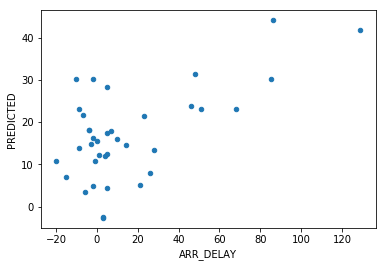

In [48]:
%matplotlib inline
compare=sample.copy()
predicted = estimator(sample.to_dict(orient='list'))
compare['PREDICTED'] = predicted['output']
compare.plot.scatter(x='ARR_DELAY', y='PREDICTED')

---
#### run the training locally

In [42]:
model_dir = 'gs://going-tfx/samples/model'
print("\n###############################################################################################################")
print("using directory {} to store the model. Remove the directory if you want to start from scratch".format(model_dir))
print("###############################################################################################################")
_ = !gsutil rm -rf $model_dir


###############################################################################################################
using directory gs://going-tfx/samples/model to store the model. Remove the directory if you want to start from scratch
###############################################################################################################


In [45]:
%%bash

# --distribute to use both GPUs with a resulting performance penalty - hence: Don't!

export PYTHONPATH=${PYTHONPATH}:${PWD}
python -m train.task \
  --base_dir=gs://going-tfx/samples/ \
  --metadata_dir=metadata \
  --train_data_pattern="train_data/atl_june_tfr*" \
  --eval_data_pattern="eval_data/atl_june_tfr*"  \
  --model_dir=model \
  --max_train_steps=20000 \
  --learning_rate=1e-3 \
  --job-dir=/tmp \
  --prefetch_buffer_size=10000

INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_task_type': 'worker', '_train_distribute': None, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f5c89ecbb50>, '_model_dir': 'gs://going-tfx/samples/model/', '_protocol': None, '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_service': None, '_num_ps_replicas': 0, '_tf_random_seed': None, '_save_summary_steps': 100, '_device_fn': None, '_experimental_distribute': None, '_num_worker_replicas': 1, '_task_id': 0, '_log_step_count_steps': 100, '_evaluation_master': '', '_eval_distribute': None, '_global_id_in_cluster': 0, '_master': ''}
INFO:tensorflow:Not using Distribute Coordinator.
INFO:tensorflow:Running training and evaluation locally (non-distributed).
INFO:tensorflow:Start train and evaluate 